# create vocabulary

In [3]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence
from nltk.corpus import gutenberg
from string import punctuation
import nltk

# download data: bible-kjv.txt
nltk.download('gutenberg')
nltk.download('punkt')
norm_bible = gutenberg.sents('bible-kjv.txt') 

# convert word to index:
norm_bible = [' '.join(doc) for doc in norm_bible]
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index

# build vocabulary of unique words :
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id)

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Vocabulary Size: 12746
Vocabulary Sample: [('the', 1), ('and', 2), ('of', 3), ('to', 4), ('that', 5), ('in', 6), ('he', 7), ('shall', 8), ('unto', 9), ('for', 10)]


# Embedding sentence by index

In [4]:
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]
print('Embedding sentence by index: ', wids[:5])

Embedding sentence by index:  [[1, 53, 1342, 6058], [1, 280, 2678, 3, 1, 53, 1342, 6058], [1, 254, 448, 3, 162, 194, 8769], [43, 43, 6, 1, 734, 27, 1368, 1, 205, 2, 1, 139], [43, 48, 2, 1, 139, 26, 258, 2085, 2, 2086, 2, 551, 26, 46, 1, 266, 3, 1, 1030]]


# Context --> Target

In [5]:
import numpy as np
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        # print('words: ', words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = [] 
            # Start index of context
            start = index - window_size
            # End index of context
            end = index + window_size + 1
            # List of context_words
            context_words.append([words[i] for i in range(start, end) if 0 <= i < sentence_length and i != index])
            # List of label_word (also is target word).
            # print('context words {}: {}'.format(context_words, index))
            label_word.append(word)
            # Padding the input 0 in the left in case it does not satisfy number of context_words = 2*window_size.
            x = sequence.pad_sequences(context_words, maxlen=context_length)
            # print('context words padded: ', x)
            # Convert label_word into one-hot vector corresponding with its index
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [6]:
# Test this out for some samples
i = 0
window_size = 2 # context window size
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['the', 'old', 'of', 'the'] -> Target (Y): testament
Context (X): ['old', 'testament', 'the', 'king'] -> Target (Y): of
Context (X): ['testament', 'of', 'king', 'james'] -> Target (Y): the
Context (X): ['of', 'the', 'james', 'bible'] -> Target (Y): king
Context (X): ['the', 'first', 'of', 'moses'] -> Target (Y): book
Context (X): ['first', 'book', 'moses', 'called'] -> Target (Y): of
Context (X): ['book', 'of', 'called', 'genesis'] -> Target (Y): moses
Context (X): ['1', '1', 'the', 'beginning'] -> Target (Y): in
Context (X): ['1', 'in', 'beginning', 'god'] -> Target (Y): the
Context (X): ['in', 'the', 'god', 'created'] -> Target (Y): beginning
Context (X): ['the', 'beginning', 'created', 'the'] -> Target (Y): god


# CBOW 

In [7]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

embed_size = 100

# build CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# view model summary
print(cbow.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 100)            1274600   
                                                                 
 lambda (Lambda)             (None, 100)               0         
                                                                 
 dense (Dense)               (None, 12746)             1287346   
                                                                 
Total params: 2,561,946
Trainable params: 2,561,946
Non-trainable params: 0
_________________________________________________________________
None


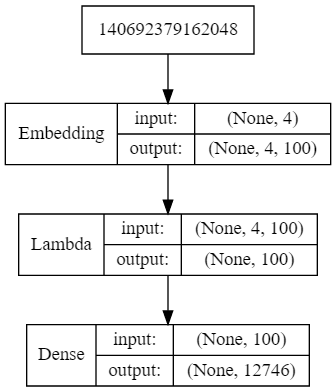

In [8]:
print('number of window: ', len(wids))

number of window:  30103


training

In [9]:
for epoch in range(1, 6):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids[:100], window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 500 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)

Processed 500 (context, word) pairs
Processed 1000 (context, word) pairs
Processed 1500 (context, word) pairs
Processed 2000 (context, word) pairs
Processed 2500 (context, word) pairs
Epoch: 1 	Loss: 20400.14939892292
Processed 500 (context, word) pairs
Processed 1000 (context, word) pairs
Processed 1500 (context, word) pairs
Processed 2000 (context, word) pairs
Processed 2500 (context, word) pairs
Epoch: 2 	Loss: 17194.029533088207
Processed 500 (context, word) pairs
Processed 1000 (context, word) pairs
Processed 1500 (context, word) pairs
Processed 2000 (context, word) pairs
Processed 2500 (context, word) pairs
Epoch: 3 	Loss: 16342.732397705317
Processed 500 (context, word) pairs
Processed 1000 (context, word) pairs
Processed 1500 (context, word) pairs
Processed 2000 (context, word) pairs
Processed 2500 (context, word) pairs
Epoch: 4 	Loss: 15539.928414106369
Processed 500 (context, word) pairs
Processed 1000 (context, word) pairs
Processed 1500 (context, word) pairs
Processed 2000 

extract embbeding words matrix

In [10]:
import pandas as pd
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

(12745, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
and,0.012835,-0.151183,0.064633,0.027602,0.423209,0.044332,-0.654585,0.414508,0.121194,-0.015842,...,-0.401650,0.000550,-0.078026,0.193919,-0.259821,0.041686,-0.032755,-0.184637,-0.635207,-0.291807
of,-0.227910,0.176314,0.051103,0.412257,0.345423,-0.052475,-0.347550,0.368479,0.114847,0.102570,...,-0.751142,-0.013073,-0.185662,-0.172678,-0.152381,1.036813,-0.100437,-0.032841,-0.168807,-0.024059
to,0.008982,0.469110,0.112339,0.432284,-0.144922,0.036024,-0.279666,0.148662,0.002813,0.001415,...,-0.100858,0.312399,-0.004509,0.039721,0.042371,0.540059,-0.011876,-0.175170,-0.066842,0.094016
that,-0.000031,0.124963,0.056811,0.114742,-0.003151,-0.027078,0.072979,0.089627,-0.016849,0.012977,...,-0.115683,0.042742,-0.073022,-0.025205,-0.043722,0.113014,-0.010762,-0.003832,-0.033299,-0.068375
in,-0.065593,-0.066591,0.036698,-0.038307,-0.037915,-0.075284,0.091576,0.205930,0.070198,-0.037988,...,-0.257351,-0.175083,-0.046118,-0.022871,-0.018633,0.246460,0.001434,0.056261,-0.071921,-0.059995


# Skip-Grams

In [11]:
from keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=window_size) for wid in wids[:100]]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(james (1342), king (53)) -> 1
(james (1342), forcible (10601)) -> 0
(bible (6058), sackcloth (1350)) -> 0
(king (53), enmishpat (8808)) -> 0
(king (53), james (1342)) -> 1
(king (53), the (1)) -> 1
(bible (6058), james (1342)) -> 1
(the (1), king (53)) -> 1
(king (53), bible (6058)) -> 1
(james (1342), queens (6769)) -> 0


In [12]:
from keras.layers import Input, Dot, dot, concatenate
# from keras.engine.input_layer import Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Sequential, Model, Input

# build skip-gram architecture
word_input = Input(shape = (1,))
word_embed = Embedding(vocab_size, embed_size,
                         embeddings_initializer="glorot_uniform",
                         input_length=1, name = 'word_embedding')(word_input)
word_output = Reshape((embed_size, ))(word_embed)
word_model = Model(word_input, word_output)

print('word_model: \n', word_model.summary())
context_input = Input(shape = (1,))
context_embed = Embedding(vocab_size, embed_size,
                  embeddings_initializer="glorot_uniform",
                  input_length=1, name = 'context_embedding')(context_input)
context_output = Reshape((embed_size,))(context_embed)
context_model = Model(context_input, context_output)
print('context_model: \n', context_model.summary())

concate = dot([word_output, context_output], axes = -1)
dense = Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid")(concate)
model = Model(inputs = [word_input, context_input], outputs = dense)
model.compile(loss="mean_squared_error", optimizer="rmsprop")

# view model summary
print('model merge word and context: \n', model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 word_embedding (Embedding)  (None, 1, 100)            1274600   
                                                                 
 reshape (Reshape)           (None, 100)               0         
                                                                 
Total params: 1,274,600
Trainable params: 1,274,600
Non-trainable params: 0
_________________________________________________________________
word_model: 
 None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 context_embedd

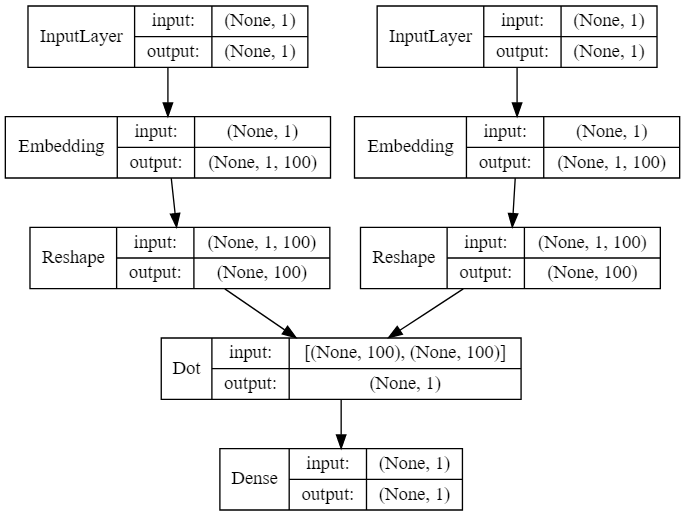

traning

In [13]:
for epoch in range(1, 6):
    loss = 0
    for i, elem in enumerate(skip_grams[:100]):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 500 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 24.618391171097755
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 21.752635836601257
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 17.85728295147419
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 4 Loss: 14.241952389478683
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 5 Loss: 11.23148162662983


extract embbeding words matrix

In [14]:
import pandas as pd

word_embedding_layer = model.get_layer('word_embedding')
weights = word_embedding_layer.get_weights()[0]

print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head()


(12746, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
the,0.017290,0.000800,0.021553,-0.003341,-0.001126,-0.015495,0.007084,0.017311,-0.003856,0.018985,...,0.010454,-0.008109,0.001497,0.005737,-0.005695,-0.009960,-0.020717,0.010137,-0.002658,0.016442
and,0.349272,0.370640,-0.363477,0.303735,-0.382827,0.375430,0.347359,-0.350941,-0.377152,-0.351820,...,0.379106,-0.373916,0.356349,0.378183,0.394117,0.046608,0.331899,-0.357871,0.354440,-0.386516
of,0.397610,0.370271,-0.413359,-0.372525,-0.417294,0.329965,0.381712,-0.409748,-0.396191,-0.397747,...,0.392895,-0.403390,0.385127,0.387403,0.411516,0.368722,0.391790,-0.376328,0.390434,-0.416716
to,0.285393,0.281695,-0.293893,-0.199772,-0.308705,0.271992,0.261637,-0.292485,-0.272827,-0.297562,...,0.297472,-0.303134,0.262963,0.280205,0.293750,0.297102,0.280699,-0.277091,0.272171,-0.288744
that,0.178905,0.180293,-0.184158,-0.153950,-0.164039,0.156413,0.167535,-0.188764,-0.161592,-0.173692,...,0.188495,-0.174275,0.162485,0.164959,0.171445,0.158350,0.198621,-0.173677,0.159513,-0.160352


testing

In [15]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['egypt', 'king']}

similar_words

(12746, 12746)


{'egypt': ['9', 'came', 'earth', 'come', '8'],
 'king': ['son', 'by', 'out', '2', 'these']}

# evaluating (t-SNE)

Total words: 12 	Word Embedding shapes: (12, 100)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


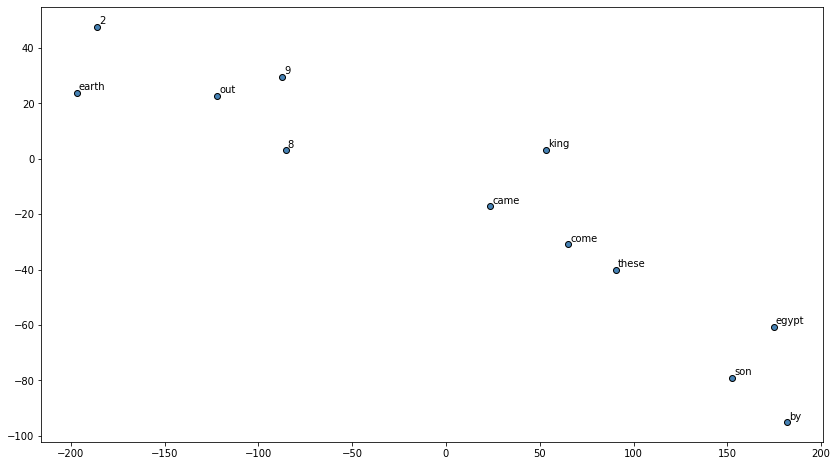

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

# the simple way : use package :)

In [17]:
from gensim.models import Word2Vec
# Training model with 1000 sentence in dataset
sentences = [[item.lower() for item in doc.split()] for doc in norm_bible[:1000]]
model = Word2Vec(sentences, min_count = 1, size = 150, window = 10, sg = 1, workers = 8)
model.train(sentences, total_examples = model.corpus_count, epochs = 10)

(210178, 336740)

In [20]:
# get embbeding vector of word "king"
print('embedding vector shape: ', model.wv['king'].shape)
model.wv['king']

embedding vector shape:  (150,)


array([ 0.04617724, -0.35040104, -0.5339661 ,  0.04296643,  0.3514211 ,
        0.04728647, -0.4424949 , -0.3735769 ,  0.03580983,  0.32808498,
        0.16668831,  0.191351  ,  0.01568864, -0.17260136,  0.00291066,
        0.01223834,  0.29464635,  0.6134726 , -0.17939404,  0.16774277,
        0.39652526, -0.07233351,  0.01316206, -0.39032817, -0.09189071,
       -0.29540566, -0.14636637, -0.11484177,  0.49222064, -0.45990172,
        0.09791552,  0.50517637,  0.23253188,  0.3205113 , -0.22112346,
        0.4216892 , -0.05563951, -0.15180755, -0.37497038, -0.41686237,
        0.21639286,  0.03846467, -0.05738993, -0.11138416, -0.02426553,
       -0.02015922, -0.2999884 , -0.07011175, -0.59034127,  0.43803567,
        0.29798552,  0.20157589,  0.4703873 , -0.25348288,  0.38885304,
        0.12002404, -0.21322916, -0.177326  , -0.10660905,  0.09766106,
        0.4685945 , -0.18805982,  0.28173703,  0.22950006, -0.10350731,
       -0.1790061 ,  0.18485042,  0.16527323,  0.32216302, -0.03

In [22]:
# get the words that are most closely related to a word based on distance
model.most_similar('king')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('admah', 0.8952584862709045),
 ('tidal', 0.8777005076408386),
 ('zeboiim', 0.8736802935600281),
 ('chedorlaomer', 0.8602940440177917),
 ('elam', 0.8588845133781433),
 ('bela', 0.8583787083625793),
 ('shinar', 0.8575802445411682),
 ('arioch', 0.853573203086853),
 ('ellasar', 0.8528846502304077),
 ('amraphel', 0.8481546640396118)]